# PET/CT Face Reconstruction

*MVA project 2022-2023*

*Authors: Emma Bou Hanna & Sebastian Partarrieu*

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/MVA/projet_medecin/

/content/gdrive/.shortcut-targets-by-id/1f9t-RCPppfaNDZTcihgrof7OtBwq91sZ/projet_medecin


In [3]:
# Saving .vtu file to see the mesh
#!pip install meshio
!pip install connected-components-3d
#!pip install meshlib
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 111.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.3
    Uninstalling nbformat-5.7.3:
      Successfully uninstalled nbformat-5.7.3


In [4]:
# Get Cascade Classifier from source
# !wget https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import nibabel as nib
import os
import seaborn as sns
import pandas as pd
import torch
import cv2
from skimage.filters import threshold_otsu, threshold_multiotsu
import cc3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
# import meshio
# import meshlib.mrmeshnumpy as me_nump
# import meshlib.mrmeshpy as me_py
from scipy.spatial.distance import directed_hausdorff
import open3d as o3d
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2gray
from PIL import Image

sns.set_style("dark")

In [6]:
from reconstruction.utils import *

In [ ]:
## store all filenames
list_ct_res_names = [] 
list_suv_names = []
for path, subdirs, files in os.walk("./subset_emma_sebastian"):
  for fname in files:
    if fname.startswith('CTres'):
      list_ct_res_names.append(os.path.join(path, fname))

    elif fname.startswith('SUV'):
      list_suv_names.append(os.path.join(path, fname))

In [ ]:
list_recons = []
for path, subdirs, files in os.walk("./tests_patients"):
  for fname in files:
    list_recons.append(os.path.join(path, fname))

In [ ]:
def show_results(proj_ct, proj_pet, proj_pet_r, mask, name_fig=None):
  x, y, w, h = mask
  plt.figure(figsize=(30,10))
  ax = plt.subplot(1,3,1)
  plt.imshow(proj_ct, cmap="gray")
  ax.add_patch(Rectangle((x,y), w, h, linewidth=2, facecolor="none", edgecolor="lightpink"))
  plt.axis("off")
  plt.title("CT")

  ax = plt.subplot(1,3,2)
  plt.imshow(proj_pet, cmap="gray")
  ax.add_patch(Rectangle((x,y), w, h, linewidth=2, facecolor="none", edgecolor="lightpink"))

  plt.axis('off')
  plt.title("PET")

  ax = plt.subplot(1,3,3)
  plt.imshow(proj_pet_r, cmap="gray")
  ax.add_patch(Rectangle((x,y), w, h, linewidth=2, facecolor="none", edgecolor="lightpink"))
  plt.title("CT from PET")
  plt.axis("off")
  if name_fig:
    plt.savefig(f"figs/{name_fig}.png")
  plt.show()

In [8]:
ct_file = nib.load(list_ct_res_names[33])
ct = ct_file.get_fdata()
otsu_ct, bin_ct, labels_ct = find_skin(ct)
morpho_ct = generate_morpho(labels_ct)
verts_ct, faces_ct, normals_ct, vals_ct = measure.marching_cubes(morpho_ct[:,:, -morpho_ct.shape[-1]//4:], .5, spacing=ct_file.header.get_zooms())
vox_dim = ct_file.header.get_zooms()
proj_ct = create_mesh(verts_ct, 
                      faces_ct, 
                      vox_dim, 
                      height=morpho_ct.shape[-1]//8)

In [ ]:
pet_file = nib.load(list_suv_names[33])
pet = pet_file.get_fdata()
otsu_pet, bin_pet, labels_pet = find_skin(pet, is_pet=True)
morpho_pet = generate_morpho(labels_pet)
verts_pet, faces_pet, normals_pet, vals_pet = measure.marching_cubes(morpho_pet[:,:,-morpho_pet.shape[-1]//4:], .5, spacing=pet_file.header.get_zooms())
vox_dim = pet_file.header.get_zooms()
proj_pet = create_mesh(verts_pet, 
                       faces_pet, 
                       vox_dim=vox_dim, 
                       height=morpho_pet.shape[-1]//8, 
                       n_it=5)

# Perform CT reconstruction with 2D UNET

In [ ]:
pet_recons_file = nib.load("tests_patients/PETCT_1e43e3d692_ct_from_pet.nii.gz")
pet_recons = pet_recons_file.get_fdata()

In [ ]:
## Reconstructed CT from PET
otsu_r, bin_pet_r, labels_r = find_skin(pet_recons)
morpho_pet_recons = generate_morpho(labels_r)
verts_pet_r, faces_pet_r, normals_pet_r, vals_pet_r = measure.marching_cubes(morpho_pet_recons[:,:,-morpho_pet_recons.shape[-1]//4:], .5, spacing=pet_recons_file.header.get_zooms())
vox_dim = pet_recons_file.header.get_zooms()
proj_pet_r = create_mesh(verts_pet_r, 
                       faces_pet_r, 
                       vox_dim=vox_dim, 
                       height=morpho_pet_recons.shape[-1]//8, 
                       n_it=5)

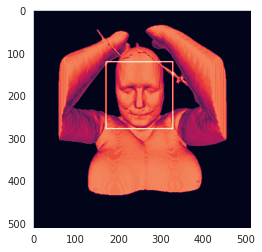

In [ ]:
mask = create_mask(proj_ct)
test = proj_ct.copy()
cv2.rectangle(test, (mask[0], mask[1]), (mask[0]+mask[2], mask[1]+mask[3]), (255, 0, 0), 2)
plt.imshow(test)

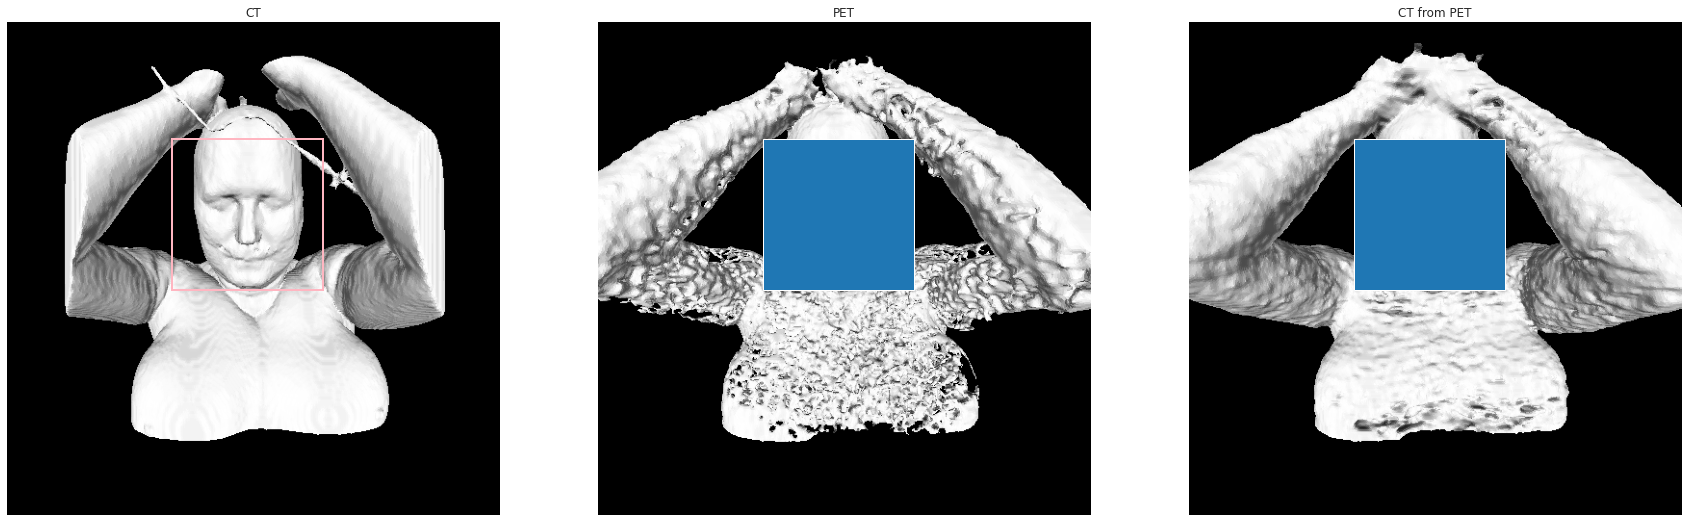

In [ ]:
show_results(proj_ct, proj_pet, proj_pet_r, mask, name_fig=None)

In [ ]:
calculate_loss(proj_ct, proj_pet, mask)

(23624.02641380169, 0.585666888800254)

In [ ]:
calculate_loss(proj_ct, proj_pet_r, mask)

(23115.682187640494, 0.5961879611551357)


## Do that for all testing data

In [ ]:
def process_data(file_name, is_pet=False):
  f = nib.load(file_name)
  data = f.get_fdata()
  otsu, bin, labels = find_skin(data, is_pet=is_pet)
  morpho = generate_morpho(labels)
  vox_dim = f.header.get_zooms()
  verts, faces, normals, vals = measure.marching_cubes(morpho[:,:, -morpho.shape[-1]//4:], .5, spacing=vox_dim)
  proj = create_mesh(verts, 
                     faces, 
                     vox_dim, 
                     height=morpho.shape[-1]//8)
  return proj

In [ ]:
dico_corres = {}
for fname in list_recons:
  for idx, fname_ in enumerate(list_ct_res_names):
    search = fname.split('tests_patients/')[1].split('_ct')[0]
    if len(fname_.split(search)) > 1:
      dico_corres[fname] = idx

In [ ]:
res = pd.DataFrame(columns=["PET/CT_rmse", "PET/CT_sim", "CT_rec/CT_rmse", "CT_rec/CT_sim"])
for file_test in dico_corres:
  idx = dico_corres[file_test]
  fig_name = file_test.split('tests_patients/')[1].split('_ct')[0]

  # find files
  pet_file = list_suv_names[idx]
  ct_file = list_ct_res_names[idx]
  pet_r_file = file_test

  # Build Face reconstruction
  proj_pet = process_data(pet_file, is_pet=True)
  proj_ct = process_data(ct_file)
  proj_pet_r = process_data(pet_r_file)
  mask = create_mask(proj_ct)
  if mask == 0:
    continue

  show_results(proj_ct, proj_pet, proj_pet_r, mask, name_fig=None)

  # Add metrics to table
  rmse, sim = calculate_loss(proj_ct, proj_pet, mask)
  res.loc[file_test, 'PET/CT_rmse'] = rmse
  res.loc[file_test, 'PET/CT_sim'] = sim

  rmse, sim = calculate_loss(proj_ct, proj_pet_r, mask)
  res.loc[file_test, 'CT_rec/CT_rmse'] = rmse 
  res.loc[file_test, 'CT_rec/CT_sim'] = sim 

In [ ]:
res

,PET/CT_rmse,PET/CT_sim,CT_rec/CT_rmse,CT_rec/CT_sim
./tests_patients/PETCT_1e43e3d692_ct_from_pet.nii.gz,148.501327,0.619927,146.22815,0.605372
./tests_patients/PETCT_02ba7e20f5_ct_from_pet.nii.gz,137.02608,0.737521,124.619488,0.643387
./tests_patients/PETCT_2f9aec0275_ct_from_pet.nii.gz,118.871472,0.749463,124.53129,0.500363
./tests_patients/PETCT_1a90052cb2_ct_from_pet.nii.gz,140.488965,0.566791,144.361934,0.626766
./tests_patients/PETCT_0fa313309d_ct_from_pet.nii.gz,114.112562,0.573722,125.382649,0.646118
./tests_patients/PETCT_0b57b247b6_ct_from_pet.nii.gz,131.551544,0.672368,131.562519,0.637663


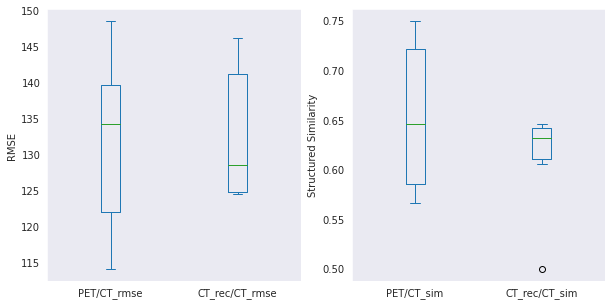

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
res[["PET/CT_rmse", "CT_rec/CT_rmse"]].plot(kind="box", ax=ax)
ax.set_ylabel("RMSE")

ax = plt.subplot(1,2,2)
res[["PET/CT_sim", "CT_rec/CT_sim"]].plot(kind="box", ax=ax)
ax.set_ylabel("Structured Similarity")
plt.savefig("figs/metrics.png")
plt.show()


# Save morpho images to be denoised

In [ ]:
import glob
already_processed_cts = glob.glob("./data_img/cts/"+"*.png")
already_processed_pets = glob.glob("./data_img/pets/"+"*.png")

In [ ]:
len(list_ct_res_names), len(already_processed_cts)

(1014, 900)

In [ ]:
def check_already_processed(fname, flist):
  for f in flist:
    if fname in f:
      return True
  return False

In [ ]:
for ct_file, pet_file in zip(list_ct_res_names, list_suv_names):
  path_save = ct_file.split("sebastian/")[1].split("/")[0]

  if check_already_processed(path_save, already_processed_cts) == False:
    proj_ct = process_data(ct_file)
    res = Image.fromarray(proj_ct)
    res.save(f"./data_img/cts/{path_save}.png", dpi=(300,300))
  
  else:
    print(f"Already processed CT {path_save}")

  if check_already_processed(path_save, already_processed_pets) == False:
    proj_pet = process_data(pet_file, is_pet=True)
    Image.fromarray(proj_pet).save(f"./data_img/pets/{path_save}.png", dpi=(300,300))
  
  else:
    print(f"Already processed PET {path_save}")

  # cv2.imwrite(f"./data_img/cts/{path_save}.jpg", proj_ct)
  # cv2.imwrite(f"./data_img/pets/{path_save}.jpg", proj_pet)

In [ ]:
## Calculate metrics over head
res = pd.DataFrame(columns=["PET/CT_rmse", "PET/CT_sim"])
for ct_file, pet_file in zip(already_processed_cts, already_processed_pets):
  assert ct_file.split('cts/')[1].split(".png")[0] == pet_file.split("pets/")[1].split(".png")[0]
  ct = np.array(Image.open(ct_file))
  pet = np.array(Image.open(pet_file))
  mask = create_mask(ct)
  if mask == 0:
    continue

  # Add metrics to table
  rmse, sim = calculate_loss(ct, pet, mask)
  res.loc[ct_file, 'PET/CT_rmse'] = rmse
  res.loc[ct_file, 'PET/CT_sim'] = sim

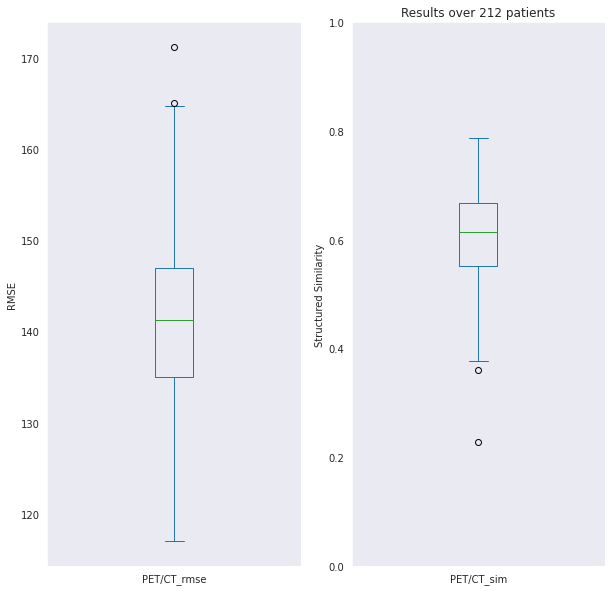

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,2,1)
res[["PET/CT_rmse"]].plot(kind="box", ax=ax)
ax.set_ylabel("RMSE")

ax2 = plt.subplot(1,2,2)
res[["PET/CT_sim"]].plot(kind="box", ax=ax2)
ax2.set_ylabel("Structured Similarity")
ax2.set_ylim((0,1))
plt.title(f"Results over {len(res)} patients")
plt.show()